# Notebook performs in_text tag predictions for the BR24 data set using Approach 3

### /data/processed_data_extra_columns.pkl is used for this notebook

### Results are saved to /data/in_text_approach_3.pkl

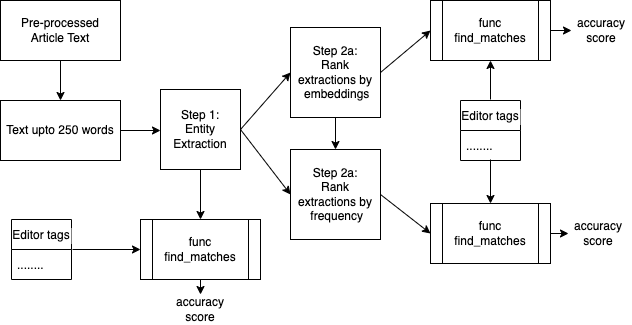

In [1]:
from IPython.display import Image

Image(filename="../images/4c-in-text-app-3.png")

In [2]:
import pickle as pk
import pandas as pd
import re

from tqdm import tqdm
tqdm.pandas()

In [2]:
df = pd.read_pickle("../data/processed_data_extra_columns.pkl", compression='zip')

In [3]:
df.shape

(40862, 16)

In [4]:
df.head(1)

,created_at,primary_category,share_url,row_id,tags,title,text,type,clean_text_tfidf,clean_text_tfidf_nltk_stem,clean_text_tfidf_spacy_lemma,clean_text,in_text,out_of_text,in_text_percent,out_of_text_percent
0,2021-08-05 09:44:27.368478+00:00,deutschland-welt,https://www.br.de/nachrichten/deutschland-welt...,SfClRxG,"[Ayatollah Ali Khamenei, Amtseinführung, Iran,...","Amtseinführung im Iran: Neuer Präsident, alte ...",&quot;Hier ist Bayern&quot;: Der BR24 Newslett...,TEXT,Bayern BR Newsletter informiert immer montags ...,Bay br Newslett informiert imm montag freitag ...,Bayer BR Newsletter informieren immer montags ...,"""Hier ist Bayern"": Der BR Newsletter informier...","[Ayatollah Ali Khamenei, Iran, Präsident, Ebra...",[Amtseinführung],80,20


# Approach 3

# Step 1: : Consider first 250 words

In [5]:
#!pip install spacy
#!python -m spacy download de_core_news_sm

In [5]:
import spacy
nlp = spacy.load('de_core_news_sm')

In [12]:
df['short_text'] = df['clean_text'].progress_apply(lambda x: ' '.join(x.split()[:250]))

100%|██████████| 40862/40862 [00:01<00:00, 26634.72it/s]


# Step 2: Entity extraction

#### Entity Extraction is done using the below steps:
- Tokenise text
- Extract ['NOUN', 'PROPN'] using POS tags in Spacy -> nouns
- Extract named entities ['PER', 'ORG', 'LOC', 'MISC'] -> ner
- Remove BR specific stopwords and overlap between nouns and ner

In [16]:
df['tokenised_text'] = df['short_text'].progress_apply(nlp)

100%|██████████| 40862/40862 [21:21<00:00, 31.87it/s]


In [18]:
pos_required = ['NOUN', 'PROPN']

df['nouns'] = df['tokenised_text'].progress_apply(lambda x: ','.join(str(word.orth_) for word in x if word.pos_ in pos_required))
df['nouns'] = [list(set(x.strip().split(','))) for x in df['nouns']]

100%|██████████| 40862/40862 [00:04<00:00, 9954.46it/s] 


In [20]:
ner_required = ['PER', 'ORG', 'LOC', 'MISC']

df['ner'] = df['tokenised_text'].progress_apply(lambda x: ','.join(str(word.text) for word in x.ents if word.label_ in ner_required))
df['ner'] = [list(set(x.strip().split(','))) for x in df['ner']]

100%|██████████| 40862/40862 [00:02<00:00, 17486.75it/s]


In [22]:
stopwords = ['Tag', 'Tage', 'Tagen', 'Ihrem', 'BR -Newsletter', 'BR', 'Woche', 'Menschen', 'Wichtigste', 'Personen', 'Jahr', 'Jahren', 'Teil', 'Stadt'] + ['Spricht ', 'Bayern', 'Br24', 'Newsletter', 'Br24-newsletter', 'Br-kultur', 'Informiert', 'Montag', 'Montags', 'Dienstag', 'Dienstags', 'Mittwoch', 'Mittwochs', 'Donnerstag', 'Donnerstags', 'Freitag', 'Freitags ', 'Feierabend', 'Wichtig', 'Wichtigste', 'Blick', 'Kompakt', 'Direkt', 'Privaten ', 'Postfach', 'Anmeldung', 'Quot', 'Ab', 'Aber', 'Abermaliges', 'Abermals', 'Abgerufen', 'Abgerufene', 'Abgerufener', 'Abgerufenes', 'Abgesehen', 'Acht', 'Aehnlich', 'Aehnliche', 'Aehnlichem', 'Aehnlichen', 'Aehnlicher', 'Aehnliches', 'Aehnlichste', 'Aehnlichstem', 'Aehnlichsten', 'Aehnlichster', 'Aehnlichstes', 'Aeusserst', 'Aeusserste', 'Aeusserstem', 'Aeussersten', 'Aeusserster', 'Aeusserstes', 'Ähnlich', 'Ähnliche', 'Ähnlichem', 'Ähnlichen', 'Ähnlicher', 'Ähnliches', 'Ähnlichst', 'Ähnlichste', 'Ähnlichstem', 'Ähnlichsten', 'Ähnlichster', 'Ähnlichstes', 'Alle', 'Allein', 'Alleine', 'Allem', 'Allemal', 'Allen', 'Allenfalls', 'Allenthalben', 'Aller', 'Allerdings', 'Allerlei', 'Alles', 'Allesamt', 'Allg', 'Allg.', 'Allgemein', 'Allgemeine', 'Allgemeinem', 'Allgemeinen', 'Allgemeiner', 'Allgemeines', 'Allgemeinste', 'Allgemeinstem', 'Allgemeinsten', 'Allgemeinster', 'Allgemeinstes', 'Allmählich', 'Allzeit', 'Allzu', 'Als', 'Alsbald', 'Also', 'Am', 'An', 'And', 'Andauernd', 'Andauernde', 'Andauerndem', 'Andauernden', 'Andauernder', 'Andauerndes', 'Ander', 'Andere', 'Anderem', 'Anderen', 'Anderenfalls', 'Anderer', 'Andererseits', 'Anderes', 'Anderm', 'Andern', 'Andernfalls', 'Anderr', 'Anders', 'Anderst', 'Anderweitig', 'Anderweitige', 'Anderweitigem', 'Anderweitigen', 'Anderweitiger', 'Anderweitiges', 'Anerkannt', 'Anerkannte', 'Anerkannter', 'Anerkanntes', 'Anfangen', 'Anfing', 'Angefangen', 'Angesetze', 'Angesetzt', 'Angesetzten', 'Angesetzter', 'Ans', 'Anscheinend', 'Ansetzen', 'Ansonst', 'Ansonsten', 'Anstatt', 'Anstelle', 'Arbeiten', 'Auch', 'Auf', 'Aufgehört', 'Aufgrund', 'Aufhören', 'Aufhörte', 'Aufzusuchen', 'Augenscheinlich', 'Augenscheinliche', 'Augenscheinlichem', 'Augenscheinlichen', 'Augenscheinlicher', 'Augenscheinliches', 'Augenscheinlichst', 'Augenscheinlichste', 'Augenscheinlichstem', 'Augenscheinlichsten', 'Augenscheinlichster', 'Augenscheinlichstes', 'Aus', 'Ausdrücken', 'Ausdrücklich', 'Ausdrückliche', 'Ausdrücklichem', 'Ausdrücklichen', 'Ausdrücklicher', 'Ausdrückliches', 'Ausdrückt', 'Ausdrückte', 'Ausgenommen', 'Ausgenommene', 'Ausgenommenem', 'Ausgenommenen', 'Ausgenommener', 'Ausgenommenes', 'Ausgerechnet', 'Ausgerechnete', 'Ausgerechnetem', 'Ausgerechneten', 'Ausgerechneter', 'Ausgerechnetes', 'Ausnahmslos', 'Ausnahmslose', 'Ausnahmslosem', 'Ausnahmslosen', 'Ausnahmsloser', 'Ausnahmsloses', 'Außen', 'Ausser', 'Ausserdem', 'Außerhalb', 'Äusserst', 'Äusserste', 'Äusserstem', 'Äussersten', 'Äusserster', 'Äusserstes', 'Author', 'Autor', 'Baelde', 'Bald', 'Bälde', 'Bearbeite', 'Bearbeiten', 'Bearbeitete', 'Bearbeiteten', 'Bedarf', 'Bedürfen', 'Bedurfte', 'Been', 'Befahl', 'Befiehlt', 'Befiehlte', 'Befohlene', 'Befohlens', 'Befragen', 'Befragte', 'Befragten', 'Befragter', 'Begann', 'Beginnen', 'Begonnen', 'Behalten', 'Behielt', 'Bei', 'Beide', 'Beidem', 'Beiden', 'Beider', 'Beiderlei', 'Beides', 'Beim', 'Beinahe', 'Beisammen', 'Beispielsweise', 'Beitragen', 'Beitrugen', 'Bekannt', 'Bekannte', 'Bekannter', 'Bekanntlich', 'Bekanntliche', 'Bekanntlichem', 'Bekanntlichen', 'Bekanntlicher', 'Bekanntliches', 'Bekennen', 'Benutzt', 'Bereits', 'Berichten', 'Berichtet', 'Berichtete', 'Berichteten', 'Besonders', 'Besser', 'Bessere', 'Besserem', 'Besseren', 'Besserer', 'Besseres', 'Bestehen', 'Besteht', 'Bestenfalls', 'Bestimmt', 'Bestimmte', 'Bestimmtem', 'Bestimmten', 'Bestimmter', 'Bestimmtes', 'Beträchtlich', 'Beträchtliche', 'Beträchtlichem', 'Beträchtlichen', 'Beträchtlicher', 'Beträchtliches', 'Betraechtlich', 'Betraechtliche', 'Betraechtlichem', 'Betraechtlichen', 'Betraechtlicher', 'Betraechtliches', 'Betreffend', 'Betreffende', 'Betreffendem', 'Betreffenden', 'Betreffender', 'Betreffendes', 'Bevor', 'Bez', 'Bez.', 'Bezgl', 'Bezgl.', 'Bezueglich', 'Bezüglich', 'Bietet', 'Bin', 'Bis', 'Bisher', 'Bisherige', 'Bisherigem', 'Bisherigen', 'Bisheriger', 'Bisheriges', 'Bislang', 'Bisschen', 'Bist', 'Bitte', 'Bleiben', 'Bleibt', 'Blieb', 'Bloss', 'Böden', 'Boeden', 'Brachte', 'Brachten', 'Brauchen', 'Braucht', 'Bräuchte', 'Bringen', 'Bsp', 'Bsp.', 'Bspw', 'Bspw.', 'Bzw', 'Bzw.', 'Ca', 'Ca.', 'Circa', 'Da', 'Dabei', 'Dadurch', 'Dafuer', 'Dafür', 'Dagegen', 'Daher', 'Dahin', 'Dahingehend', 'Dahingehende', 'Dahingehendem', 'Dahingehenden', 'Dahingehender', 'Dahingehendes', 'Dahinter', 'Damalige', 'Damaligem', 'Damaligen', 'Damaliger', 'Damaliges', 'Damals', 'Damit', 'Danach', 'Daneben', 'Dank', 'Danke', 'Danken', 'Dann', 'Dannen', 'Daran', 'Darauf', 'Daraus', 'Darf', 'Darfst', 'Darin', 'Darüber', 'Darüberhinaus', 'Darueber', 'Darueberhinaus', 'Darum', 'Darunter', 'Das', 'Daß', 'Dass', 'Dasselbe', 'Dat', 'Davon', 'Davor', 'Dazu', 'Dazwischen', 'Dein', 'Deine', 'Deinem', 'Deinen', 'Deiner', 'Deines', 'Dem', 'Demgegenüber', 'Demgegenueber', 'Demgemaess', 'Demgemäss', 'Demnach', 'Demselben', 'Den', 'Denen', 'Denkbar', 'Denkbare', 'Denkbarem', 'Denkbaren', 'Denkbarer', 'Denkbares', 'Denn', 'Dennoch', 'Denselben', 'Der', 'Derart', 'Derartig', 'Derartige', 'Derartigem', 'Derartigen', 'Derartiger', 'Derem', 'Deren', 'Derer', 'Derjenige', 'Derjenigen', 'Derselbe', 'Derselben', 'Derzeit', 'Derzeitig', 'Derzeitige', 'Derzeitigem', 'Derzeitigen', 'Derzeitiges', 'Des', 'Deshalb', 'Desselben', 'Dessen', 'Dessenungeachtet', 'Desto', 'Desungeachtet', 'Deswegen', 'Dich', 'Die', 'Diejenige', 'Diejenigen', 'Dies', 'Diese', 'Dieselbe', 'Dieselben', 'Diesem', 'Diesen', 'Dieser', 'Dieses', 'Diesseitig', 'Diesseitige', 'Diesseitigem', 'Diesseitigen', 'Diesseitiger', 'Diesseitiges', 'Diesseits', 'Dinge', 'Dir', 'Direkt', 'Direkte', 'Direkten', 'Direkter', 'Doch', 'Doppelt', 'Dort', 'Dorther', 'Dorthin', 'Dr', 'Dr.', 'Dran', 'Drauf', 'Drei', 'Dreißig', 'Drin', 'Dritte', 'Drüber', 'Drueber', 'Drum', 'Drunter', 'Du', 'Duerfte', 'Duerften', 'Duerftest', 'Duerftet', 'Dunklen', 'Durch', 'Durchaus', 'Durchweg', 'Durchwegs', 'Dürfen', 'Durfte', 'Dürfte', 'Durften', 'Dürften', 'Durftest', 'Dürftest', 'Durftet', 'Dürftet', 'Eben', 'Ebenfalls', 'Ebenso', 'Ect', 'Ect.', 'Ehe', 'Eher', 'Eheste', 'Ehestem', 'Ehesten', 'Ehester', 'Ehestes', 'Eigen', 'Eigene', 'Eigenem', 'Eigenen', 'Eigener', 'Eigenes', 'Eigenst', 'Eigentlich', 'Eigentliche', 'Eigentlichem', 'Eigentlichen', 'Eigentlicher', 'Eigentliches', 'Ein', 'Einbaün', 'Eine', 'Einem', 'Einen', 'Einer', 'Einerlei', 'Einerseits', 'Eines', 'Einfach', 'Einführen', 'Einführte', 'Einführten', 'Eingesetzt', 'Einig', 'Einige', 'Einigem', 'Einigen', 'Einiger', 'Einigermaßen', 'Einiges', 'Einmal', 'Einmalig', 'Einmalige', 'Einmaligem', 'Einmaligen', 'Einmaliger', 'Einmaliges', 'Eins', 'Einseitig', 'Einseitige', 'Einseitigen', 'Einseitiger', 'Einst', 'Einstmals', 'Einzig', 'Empfunden', 'Ende', 'Entgegen', 'Entlang', 'Entsprechend', 'Entsprechende', 'Entsprechendem', 'Entsprechenden', 'Entsprechender', 'Entsprechendes', 'Entweder', 'Er', 'Ergänze', 'Ergänzen', 'Ergänzte', 'Ergänzten', 'Ergo', 'Erhält', 'Erhalten', 'Erhielt', 'Erhielten', 'Erneut', 'Eröffne', 'Eröffnen', 'Eröffnet', 'Eröffnete', 'Eröffnetes', 'Erscheinen', 'Erst', 'Erste', 'Erstem', 'Ersten', 'Erster', 'Erstere', 'Ersterem', 'Ersteren', 'Ersterer', 'Ersteres', 'Erstes', 'Es', 'Etc', 'Etc.', 'Etliche', 'Etlichem', 'Etlichen', 'Etlicher', 'Etliches', 'Etwa', 'Etwaige', 'Etwas', 'Euch', 'Euer', 'Eure', 'Eurem', 'Euren', 'Eurer', 'Eures', 'Euretwegen', 'Fall', 'Falls', 'Fand', 'Fast', 'Ferner', 'Fertig', 'Finde', 'Finden', 'Findest', 'Findet', 'Folgend', 'Folgende', 'Folgendem', 'Folgenden', 'Folgender', 'Folgendermassen', 'Folgendes', 'Folglich', 'For', 'Fordern', 'Fordert', 'Forderte', 'Forderten', 'Fort', 'Fortsetzen', 'Fortsetzt', 'Fortsetzte', 'Fortsetzten', 'Fragte', 'Frau', 'Frei', 'Freie', 'Freier', 'Freies', 'Fuer', 'Fuers', 'Fünf', 'Für', 'Fürs', 'Gab', 'Gaenzlich', 'Gaenzliche', 'Gaenzlichem', 'Gaenzlichen', 'Gaenzlicher', 'Gaenzliches', 'Gängig', 'Gängige', 'Gängigen', 'Gängiger', 'Gängiges', 'Ganz', 'Ganze', 'Ganzem', 'Ganzen', 'Ganzer', 'Ganzes', 'Gänzlich', 'Gänzliche', 'Gänzlichem', 'Gänzlichen', 'Gänzlicher', 'Gänzliches', 'Gar', 'Gbr', 'Geb', 'Geben', 'Geblieben', 'Gebracht', 'Gedurft', 'Geehrt', 'Geehrte', 'Geehrten', 'Geehrter', 'Gefallen', 'Gefälligst', 'Gefällt', 'Gefiel', 'Gegeben', 'Gegen', 'Gegenüber', 'Gegenueber', 'Gehabt', 'Gehalten', 'Gehen', 'Geht', 'Gekommen', 'Gekonnt', 'Gemacht', 'Gemaess', 'Gemäss', 'Gemeinhin', 'Gemocht', 'Genau', 'Genommen', 'Genug', 'Gepriesener', 'Gepriesenes', 'Gerade', 'Gern', 'Gesagt', 'Gesehen', 'Gestern', 'Gestrige', 'Getan', 'Geteilt', 'Geteilte', 'Getragen', 'Getrennt', 'Gewesen', 'Gewiss', 'Gewisse', 'Gewissem', 'Gewissen', 'Gewisser', 'Gewissermaßen', 'Gewisses', 'Gewollt', 'Geworden', 'Ggf', 'Ggf.', 'Gib', 'Gibt', 'Gilt', 'Gleich', 'Gleiche', 'Gleichem', 'Gleichen', 'Gleicher', 'Gleiches', 'Gleichsam', 'Gleichste', 'Gleichstem', 'Gleichsten', 'Gleichster', 'Gleichstes', 'Gleichwohl', 'Gleichzeitig', 'Gleichzeitige', 'Gleichzeitigem', 'Gleichzeitigen', 'Gleichzeitiger', 'Gleichzeitiges', 'Glücklicherweise', 'Gluecklicherweise', 'Gmbh', 'Gottseidank', 'Gratulieren', 'Gratuliert', 'Gratulierte', 'Groesstenteils', 'Grösstenteils', 'Gruendlich', 'Gründlich', 'Gut', 'Gute', 'Guten', 'Hab', 'Habe', 'Haben', 'Habt', 'Haette', 'Haeufig', 'Haeufige', 'Haeufigem', 'Haeufigen', 'Haeufiger', 'Haeufigere', 'Haeufigeren', 'Haeufigerer', 'Haeufigeres', 'Halb', 'Hallo', 'Halten', 'Hast', 'Hat', 'Hätt', 'Hatte', 'Hätte', 'Hatten', 'Hätten', 'Hattest', 'Hattet', 'Häufig', 'Häufige', 'Häufigem', 'Häufigen', 'Häufiger', 'Häufigere', 'Häufigeren', 'Häufigerer', 'Häufigeres', 'Hen', 'Her', 'Herr', 'Heraus', 'Herein', 'Herum', 'Heute', 'Heutige', 'Heutigem', 'Heutigen', 'Heutiger', 'Heutiges', 'Hier', 'Hierbei', 'Hiermit', 'Hiesige', 'Hiesigem', 'Hiesigen', 'Hiesiger', 'Hiesiges', 'Hin', 'Hindurch', 'Hinein', 'Hingegen', 'Hinlanglich', 'Hinlänglich', 'Hinten', 'Hintendran', 'Hinter', 'Hinterher', 'Hinterm', 'Hintern', 'Hinunter', 'Hoch', 'Höchst', 'Höchstens', 'Http', 'Hundert', 'Ich', 'Igitt', 'Ihm', 'Ihn', 'Ihnen', 'Ihr', 'Ihre', 'Ihrem', 'Ihren', 'Ihrer', 'Ihres', 'Ihretwegen', 'Ihrige', 'Ihrigen', 'Ihriges', 'Im', 'Immer', 'Immerhin', 'Immerwaehrend', 'Immerwaehrende', 'Immerwaehrendem', 'Immerwaehrenden', 'Immerwaehrender', 'Immerwaehrendes', 'Immerwährend', 'Immerwährende', 'Immerwährendem', 'Immerwährenden', 'Immerwährender', 'Immerwährendes', 'Immerzu', 'Important', 'In', 'Indem', 'Indessen', 'Inf.', 'Info', 'Infolge', 'Infolgedessen', 'Information', 'Innen', 'Innerhalb', 'Innerlich', 'Ins', 'Insbesondere', 'Insgeheim', 'Insgeheime', 'Insgeheimer', 'Insgesamt', 'Insgesamte', 'Insgesamter', 'Insofern', 'Inzwischen', 'Irgend', 'Irgendein', 'Irgendeine', 'Irgendeinem', 'Irgendeiner', 'Irgendeines', 'Irgendetwas', 'Irgendjemand', 'Irgendjemandem', 'Irgendwann', 'Irgendwas', 'Irgendwelche', 'Irgendwen', 'Irgendwenn', 'Irgendwer', 'Irgendwie', 'Irgendwo', 'Irgendwohin', 'Ist', 'Ja', 'Jaehrig', 'Jaehrige', 'Jaehrigem', 'Jaehrigen', 'Jaehriger', 'Jaehriges', 'Jährig', 'Jährige', 'Jährigem', 'Jährigen', 'Jähriges', 'Je', 'Jede', 'Jedem', 'Jeden', 'Jedenfalls', 'Jeder', 'Jederlei', 'Jedes', 'Jedesmal', 'Jedoch', 'Jeglichem', 'Jeglichen', 'Jeglicher', 'Jegliches', 'Jemals', 'Jemand', 'Jemandem', 'Jemanden', 'Jemandes', 'Jene', 'Jenem', 'Jenen', 'Jener', 'Jenes', 'Jenseitig', 'Jenseitigem', 'Jenseitiger', 'Jenseits', 'Jetzt', 'Jung', 'Junge', 'Jungem', 'Jungen', 'Junger', 'Junges', 'Kaeumlich', 'Kam', 'Kann', 'Kannst', 'Kaum', 'Käumlich', 'Kein', 'Keine', 'Keinem', 'Keinen', 'Keiner', 'Keinerlei', 'Keines', 'Keineswegs', 'Klar', 'Klare', 'Klaren', 'Klares', 'Klein', 'Kleinen', 'Kleiner', 'Kleines', 'Koennen', 'Koennt', 'Koennte', 'Koennten', 'Koenntest', 'Koenntet', 'Komme', 'Kommen', 'Kommt', 'Konkret', 'Konkrete', 'Konkreten', 'Konkreter', 'Konkretes', 'Könn', 'Können', 'Könnt', 'Konnte', 'Könnte', 'Konnten', 'Könnten', 'Konntest', 'Könntest', 'Konntet', 'Könntet', 'Kuenftig', 'Kuerzlich', 'Kuerzlichst', 'Künftig', 'Kürzlich', 'Kürzlichst', 'Laengst', 'Lag', 'Lagen', 'Langsam', 'Längst', 'Längstens', 'Lassen', 'Laut', 'Lediglich', 'Leer', 'Legen', 'Legte', 'Legten', 'Leicht', 'Leider', 'Lesen', 'Letze', 'Letzte', 'Letzten', 'Letztendlich', 'Letztens', 'Letztere', 'Letzterem', 'Letzterer', 'Letzteres', 'Letztes', 'Letztlich', 'Lichten', 'Liegt', 'Liest', 'Links', 'Mache', 'Machen', 'Machst', 'Macht', 'Machte', 'Machten', 'Mag', 'Magst', 'Mal', 'Man', 'Manch', 'Manche', 'Manchem', 'Manchen', 'Mancher', 'Mancherlei', 'Mancherorts', 'Manches', 'Manchmal', 'Mann', 'Margin', 'Massgebend', 'Massgebende', 'Massgebendem', 'Massgebenden', 'Massgebender', 'Massgebendes', 'Massgeblich', 'Massgebliche', 'Massgeblichem', 'Massgeblichen', 'Massgeblicher', 'Mehr', 'Mehrere', 'Mehrerer', 'Mehrfach', 'Mehrmalig', 'Mehrmaligem', 'Mehrmaliger', 'Mehrmaliges', 'Mein', 'Meine', 'Meinem', 'Meinen', 'Meiner', 'Meines', 'Meinetwegen', 'Meins', 'Meist', 'Meiste', 'Meisten', 'Meistens', 'Meistenteils', 'Meta', 'Mich', 'Mindestens', 'Mir', 'Mit', 'Miteinander', 'Mitgleich', 'Mithin', 'Mitnichten', 'Mittels', 'Mittelst', 'Mitten', 'Mittig', 'Mitunter', 'Mitwohl', 'Mochte', 'Möchte', 'Möchten', 'Möchtest', 'Moechte', 'Moeglich', 'Moeglichst', 'Moeglichste', 'Moeglichstem', 'Moeglichsten', 'Moeglichster', 'Mögen', 'Möglich', 'Mögliche', 'Möglichen', 'Möglicher', 'Möglicherweise', 'Möglichst', 'Möglichste', 'Möglichstem', 'Möglichsten', 'Möglichster', 'Morgen', 'Morgige', 'Muessen', 'Muesst', 'Muesste', 'Muss', 'Müssen', 'Musst', 'Müßt', 'Musste', 'Müsste', 'Mussten', 'Müssten', 'Nach', 'Nachdem', 'Nacher', 'Nachher', 'Nachhinein', 'Nächste', 'Nacht', 'Naechste', 'Naemlich', 'Nahm', 'Nämlich', 'Naturgemaess', 'Naturgemäss', 'Natürlich', 'Ncht', 'Neben', 'Nebenan', 'Nehmen', 'Nein', 'Neu', 'Neue', 'Neuem', 'Neuen', 'Neuer', 'Neuerdings', 'Neuerlich', 'Neuerliche', 'Neuerlichem', 'Neuerlicher', 'Neuerliches', 'Neues', 'Neulich', 'Neun', 'Nicht', 'Nichts', 'Nichtsdestotrotz', 'Nichtsdestoweniger', 'Nie', 'Niemals', 'Niemand', 'Niemandem', 'Niemanden', 'Niemandes', 'Nimm', 'Nimmer', 'Nimmt', 'Nirgends', 'Nirgendwo', 'Noch', 'Noetigenfalls', 'Nötigenfalls', 'Nun', 'Nur', 'Nutzen', 'Nutzt', 'Nützt', 'Nutzung', 'Ob', 'Oben', 'Ober', 'Oberen', 'Oberer', 'Oberhalb', 'Oberste', 'Obersten', 'Oberster', 'Obgleich', 'Obs', 'Obschon', 'Obwohl', 'Oder', 'Oefter', 'Oefters', 'Off', 'Offenkundig', 'Offenkundige', 'Offenkundigem', 'Offenkundigen', 'Offenkundiger', 'Offenkundiges', 'Offensichtlich', 'Offensichtliche', 'Offensichtlichem', 'Offensichtlichen', 'Offensichtlicher', 'Offensichtliches', 'Oft', 'Öfter', 'Öfters', 'Oftmals', 'Ohne', 'Ohnedies', 'Online', 'Paar', 'Partout', 'Per', 'Persoenlich', 'Persoenliche', 'Persoenlichem', 'Persoenlicher', 'Persoenliches', 'Persönlich', 'Persönliche', 'Persönlicher', 'Persönliches', 'Pfui', 'Ploetzlich', 'Ploetzliche', 'Ploetzlichem', 'Ploetzlicher', 'Ploetzliches', 'Plötzlich', 'Plötzliche', 'Plötzlichem', 'Plötzlicher', 'Plötzliches', 'Pro', 'Quasi', 'Reagiere', 'Reagieren', 'Reagiert', 'Reagierte', 'Recht', 'Rechts', 'Regelmäßig', 'Reichlich', 'Reichliche', 'Reichlichem', 'Reichlichen', 'Reichlicher', 'Restlos', 'Restlose', 'Restlosem', 'Restlosen', 'Restloser', 'Restloses', 'Richtiggehend', 'Richtiggehende', 'Richtiggehendem', 'Richtiggehenden', 'Richtiggehender', 'Richtiggehendes', 'Rief', 'Rund', 'Rundheraus', 'Rundum', 'Runter', 'S', 'Sage', 'Sagen', 'Sagt', 'Sagte', 'Sagten', 'Sagtest', 'Sagtet', 'Samt', 'Sämtliche', 'Sang', 'Sangen', 'Sattsam', 'Schätzen', 'Schätzt', 'Schätzte', 'Schätzten', 'Scheinbar', 'Scheinen', 'Schlechter', 'Schlicht', 'Schlichtweg', 'Schließlich', 'Schlussendlich', 'Schnell', 'Schon', 'Schreibe', 'Schreiben', 'Schreibens', 'Schreiber', 'Schwerlich', 'Schwerliche', 'Schwerlichem', 'Schwerlichen', 'Schwerlicher', 'Schwerliches', 'Schwierig', 'Sechs', 'Sect', 'Sehe', 'Sehen', 'Sehr', 'Sehrwohl', 'Seht', 'Sei', 'Seid', 'Seien', 'Seiest', 'Seiet', 'Sein', 'Seine', 'Seinem', 'Seinen', 'Seiner', 'Seines', 'Seit', 'Seitdem', 'Seite', 'Seiten', 'Seither', 'Selbe', 'Selben', 'Selber', 'Selbst', 'Selbstredend', 'Selbstredende', 'Selbstredendem', 'Selbstredenden', 'Selbstredender', 'Selbstredendes', 'Seltsamerweise', 'Senke', 'Senken', 'Senkt', 'Senkte', 'Senkten', 'Setzen', 'Setzt', 'Setzte', 'Setzten', 'Sich', 'Sicher', 'Sicherlich', 'Sie', 'Sieben', 'Siebte', 'Siehe', 'Sieht', 'Sind', 'Singen', 'Singt', 'So', 'Sobald', 'Sodaß', 'Soeben', 'Sofern', 'Sofort', 'Sog', 'Sogar', 'Sogleich', 'Solange', 'Solc', 'Solc hen', 'Solch', 'Solche', 'Solchem', 'Solchen', 'Solcher', 'Solches', 'Soll', 'Sollen', 'Sollst', 'Sollt', 'Sollte', 'Sollten', 'Solltest', 'Solltet', 'Somit', 'Sondern', 'Sonst', 'Sonstig', 'Sonstige', 'Sonstigem', 'Sonstiger', 'Sonstwo', 'Sooft', 'Soviel', 'Soweit', 'Sowie', 'Sowieso', 'Sowohl', 'Später', 'Spielen', 'Startet', 'Startete', 'Starteten', 'Statt', 'Stattdessen', 'Steht', 'Steige', 'Steigen', 'Steigt', 'Stellenweise', 'Stellenweisem', 'Stellenweisen', 'Stets', 'Stieg', 'Stiegen', 'Such', 'Suchen', 'Tages', 'Tat', 'Tät', 'Tatsächlich', 'Tatsächlichen', 'Tatsächlicher', 'Tatsächliches', 'Tatsaechlich', 'Tatsaechlichen', 'Tatsaechlicher', 'Tatsaechliches', 'Tausend', 'Teile', 'Teilen', 'Teilte', 'Teilten', 'Tief', 'Titel', 'Toll', 'Total', 'Trage', 'Tragen', 'Trägt', 'Trotzdem', 'Trug', 'Tun', 'Tust', 'Tut', 'Txt', 'Übel', 'Über', 'Überall', 'Überallhin', 'Überaus', 'Überdies', 'Überhaupt', 'Überll', 'Übermorgen', 'Üblicherweise', 'Übrig', 'Übrigens', 'Ueber', 'Ueberall', 'Ueberallhin', 'Ueberaus', 'Ueberdies', 'Ueberhaupt', 'Uebermorgen', 'Ueblicherweise', 'Uebrig', 'Uebrigens', 'Um', 'Ums', 'Umso', 'Umstaendehalber', 'Umständehalber', 'Unbedingt', 'Unbedingte', 'Unbedingter', 'Unbedingtes', 'Und', 'Unerhoert', 'Unerhoerte', 'Unerhoertem', 'Unerhoerten', 'Unerhoerter', 'Unerhoertes', 'Unerhört', 'Unerhörte', 'Unerhörtem', 'Unerhörten', 'Unerhörter', 'Unerhörtes', 'Ungefähr', 'Ungemein', 'Ungewoehnlich', 'Ungewoehnliche', 'Ungewoehnlichem', 'Ungewoehnlichen', 'Ungewoehnlicher', 'Ungewoehnliches', 'Ungewöhnlich', 'Ungewöhnliche', 'Ungewöhnlichem', 'Ungewöhnlichen', 'Ungewöhnlicher', 'Ungewöhnliches', 'Ungleich', 'Ungleiche', 'Ungleichem', 'Ungleichen', 'Ungleicher', 'Ungleiches', 'Unmassgeblich', 'Unmassgebliche', 'Unmassgeblichem', 'Unmassgeblichen', 'Unmassgeblicher', 'Unmassgebliches', 'Unmoeglich', 'Unmoegliche', 'Unmoeglichem', 'Unmoeglichen', 'Unmoeglicher', 'Unmoegliches', 'Unmöglich', 'Unmögliche', 'Unmöglichen', 'Unmöglicher', 'Unnötig', 'Uns', 'Unsaeglich', 'Unsaegliche', 'Unsaeglichem', 'Unsaeglichen', 'Unsaeglicher', 'Unsaegliches', 'Unsagbar', 'Unsagbare', 'Unsagbarem', 'Unsagbaren', 'Unsagbarer', 'Unsagbares', 'Unsäglich', 'Unsägliche', 'Unsäglichem', 'Unsäglichen', 'Unsäglicher', 'Unsägliches', 'Unse', 'Unsem', 'Unsen', 'Unser', 'Unsere', 'Unserem', 'Unseren', 'Unserer', 'Unseres', 'Unserm', 'Unses', 'Unsre', 'Unsrem', 'Unsren', 'Unsrer', 'Unsres', 'Unstreitig', 'Unstreitige', 'Unstreitigem', 'Unstreitigen', 'Unstreitiger', 'Unstreitiges', 'Unten', 'Unter', 'Unterbrach', 'Unterbrechen', 'Untere', 'Unterem', 'Unteres', 'Unterhalb', 'Unterste', 'Unterster', 'Unterstes', 'Unwichtig', 'Unzweifelhaft', 'Unzweifelhafte', 'Unzweifelhaftem', 'Unzweifelhaften', 'Unzweifelhafter', 'Unzweifelhaftes', 'Usw', 'Usw.', 'Vergangen', 'Vergangene', 'Vergangener', 'Vergangenes', 'Vermag', 'Vermögen', 'Vermutlich', 'Vermutliche', 'Vermutlichem', 'Vermutlichen', 'Vermutlicher', 'Vermutliches', 'Veröffentlichen', 'Veröffentlicher', 'Veröffentlicht', 'Veröffentlichte', 'Veröffentlichten', 'Veröffentlichtes', 'Verrate', 'Verraten', 'Verriet', 'Verrieten', 'Version', 'Versorge', 'Versorgen', 'Versorgt', 'Versorgte', 'Versorgten', 'Versorgtes', 'Viel', 'Viele', 'Vielen', 'Vieler', 'Vielerlei', 'Vieles', 'Vielleicht', 'Vielmalig', 'Vielmals', 'Vier', 'Voellig', 'Voellige', 'Voelligem', 'Voelligen', 'Voelliger', 'Voelliges', 'Voelligst', 'Vollends', 'Völlig', 'Völlige', 'Völligem', 'Völligen', 'Völliger', 'Völliges', 'Völligst', 'Vollstaendig', 'Vollstaendige', 'Vollstaendigem', 'Vollstaendigen', 'Vollstaendiger', 'Vollstaendiges', 'Vollständig', 'Vollständige', 'Vollständigem', 'Vollständigen', 'Vollständiger', 'Vollständiges', 'Vom', 'Von', 'Vor', 'Voran', 'Vorbei', 'Vorgestern', 'Vorher', 'Vorherig', 'Vorherige', 'Vorherigem', 'Vorheriger', 'Vorne', 'Vorüber', 'Vorueber', 'Wachen', 'Waehrend', 'Waehrenddessen', 'Waere', 'Während', 'Währenddessen', 'Wann', 'War', 'Wär', 'Wäre', 'Waren', 'Wären', 'Warst', 'Wart', 'Warum', 'Was', 'Weder', 'Weg', 'Wegen', 'Weil', 'Weiß', 'Weit', 'Weiter', 'Weitere', 'Weiterem', 'Weiteren', 'Weiterer', 'Weiteres', 'Weiterhin', 'Weitestgehend', 'Weitestgehende', 'Weitestgehendem', 'Weitestgehenden', 'Weitestgehender', 'Weitestgehendes', 'Weitgehend', 'Weitgehende', 'Weitgehendem', 'Weitgehenden', 'Weitgehender', 'Weitgehendes', 'Welche', 'Welchem', 'Welchen', 'Welcher', 'Welches', 'Wem', 'Wen', 'Wenig', 'Wenige', 'Weniger', 'Wenigstens', 'Wenn', 'Wenngleich', 'Wer', 'Werde', 'Werden', 'Werdet', 'Weshalb', 'Wessen', 'Weswegen', 'Wichtig', 'Wie', 'Wieder', 'Wiederum', 'Wieso', 'Wieviel', 'Wieviele', 'Wievieler', 'Wiewohl', 'Will', 'Willst', 'Wir', 'Wird', 'Wirklich', 'Wirklichem', 'Wirklicher', 'Wirkliches', 'Wirst', 'Wo', 'Wobei', 'Wodurch', 'Wofuer', 'Wofür', 'Wogegen', 'Woher', 'Wohin', 'Wohingegen', 'Wohl', 'Wohlgemerkt', 'Wohlweislich', 'Wolle', 'Wollen', 'Wollt', 'Wollte', 'Wollten', 'Wolltest', 'Wolltet', 'Womit', 'Womoeglich', 'Womoegliche', 'Womoeglichem', 'Womoeglichen', 'Womoeglicher', 'Womoegliches', 'Womöglich', 'Womögliche', 'Womöglichem', 'Womöglichen', 'Womöglicher', 'Womögliches', 'Woran', 'Woraufhin', 'Woraus', 'Worden', 'Worin', 'Wuerde', 'Wuerden', 'Wuerdest', 'Wuerdet', 'Wurde', 'Würde', 'Wurden', 'Würden', 'Wurdest', 'Würdest', 'Wurdet', 'Würdet', 'Www', 'X', 'Z.b.', 'Zahlreich', 'Zahlreichem', 'Zahlreicher', 'Zb', 'Zb.', 'Zehn', 'Zeitweise', 'Zeitweisem', 'Zeitweisen', 'Zeitweiser', 'Ziehen', 'Zieht', 'Ziemlich', 'Ziemliche', 'Ziemlichem', 'Ziemlichen', 'Ziemlicher', 'Ziemliches', 'Zirka', 'Zog', 'Zogen', 'Zu', 'Zudem', 'Zuerst', 'Zufolge', 'Zugleich', 'Zuletzt', 'Zum', 'Zumal', 'Zumeist', 'Zumindest', 'Zunächst', 'Zunaechst', 'Zur', 'Zurück', 'Zurueck', 'Zusammen', 'Zusehends', 'Zuviel', 'Zuviele', 'Zuvieler', 'Zuweilen', 'Zwanzig', 'Zwar', 'Zwei', 'Zweifelsfrei', 'Zweifelsfreie', 'Zweifelsfreiem', 'Zweifelsfreien', 'Zweifelsfreier', 'Zweifelsfreies', 'Zwischen', 'Zwölf', 'spricht ', 'bayern', 'br24', 'newsletter', 'br24-newsletter', 'br-kultur', 'informiert', 'montag', 'montags', 'dienstag', 'dienstags', 'mittwoch', 'mittwochs', 'donnerstag', 'donnerstags', 'freitag', 'freitags ', 'feierabend', 'wichtig', 'wichtigste', 'blick', 'kompakt', 'direkt', 'privaten ', 'postfach', 'anmeldung', 'quot', 'ab', 'aber', 'abermaliges', 'abermals', 'abgerufen', 'abgerufene', 'abgerufener', 'abgerufenes', 'abgesehen', 'acht', 'aehnlich', 'aehnliche', 'aehnlichem', 'aehnlichen', 'aehnlicher', 'aehnliches', 'aehnlichste', 'aehnlichstem', 'aehnlichsten', 'aehnlichster', 'aehnlichstes', 'aeusserst', 'aeusserste', 'aeusserstem', 'aeussersten', 'aeusserster', 'aeusserstes', 'ähnlich', 'ähnliche', 'ähnlichem', 'ähnlichen', 'ähnlicher', 'ähnliches', 'ähnlichst', 'ähnlichste', 'ähnlichstem', 'ähnlichsten', 'ähnlichster', 'ähnlichstes', 'alle', 'allein', 'alleine', 'allem', 'allemal', 'allen', 'allenfalls', 'allenthalben', 'aller', 'allerdings', 'allerlei', 'alles', 'allesamt', 'allg', 'allg.', 'allgemein', 'allgemeine', 'allgemeinem', 'allgemeinen', 'allgemeiner', 'allgemeines', 'allgemeinste', 'allgemeinstem', 'allgemeinsten', 'allgemeinster', 'allgemeinstes', 'allmählich', 'allzeit', 'allzu', 'als', 'alsbald', 'also', 'am', 'an', 'and', 'andauernd', 'andauernde', 'andauerndem', 'andauernden', 'andauernder', 'andauerndes', 'ander', 'andere', 'anderem', 'anderen', 'anderenfalls', 'anderer', 'andererseits', 'anderes', 'anderm', 'andern', 'andernfalls', 'anderr', 'anders', 'anderst', 'anderweitig', 'anderweitige', 'anderweitigem', 'anderweitigen', 'anderweitiger', 'anderweitiges', 'anerkannt', 'anerkannte', 'anerkannter', 'anerkanntes', 'anfangen', 'anfing', 'angefangen', 'angesetze', 'angesetzt', 'angesetzten', 'angesetzter', 'ans', 'anscheinend', 'ansetzen', 'ansonst', 'ansonsten', 'anstatt', 'anstelle', 'arbeiten', 'auch', 'auf', 'aufgehört', 'aufgrund', 'aufhören', 'aufhörte', 'aufzusuchen', 'augenscheinlich', 'augenscheinliche', 'augenscheinlichem', 'augenscheinlichen', 'augenscheinlicher', 'augenscheinliches', 'augenscheinlichst', 'augenscheinlichste', 'augenscheinlichstem', 'augenscheinlichsten', 'augenscheinlichster', 'augenscheinlichstes', 'aus', 'ausdrücken', 'ausdrücklich', 'ausdrückliche', 'ausdrücklichem', 'ausdrücklichen', 'ausdrücklicher', 'ausdrückliches', 'ausdrückt', 'ausdrückte', 'ausgenommen', 'ausgenommene', 'ausgenommenem', 'ausgenommenen', 'ausgenommener', 'ausgenommenes', 'ausgerechnet', 'ausgerechnete', 'ausgerechnetem', 'ausgerechneten', 'ausgerechneter', 'ausgerechnetes', 'ausnahmslos', 'ausnahmslose', 'ausnahmslosem', 'ausnahmslosen', 'ausnahmsloser', 'ausnahmsloses', 'außen', 'ausser', 'ausserdem', 'außerhalb', 'äusserst', 'äusserste', 'äusserstem', 'äussersten', 'äusserster', 'äusserstes', 'author', 'autor', 'baelde', 'bald', 'bälde', 'bearbeite', 'bearbeiten', 'bearbeitete', 'bearbeiteten', 'bedarf', 'bedürfen', 'bedurfte', 'been', 'befahl', 'befiehlt', 'befiehlte', 'befohlene', 'befohlens', 'befragen', 'befragte', 'befragten', 'befragter', 'begann', 'beginnen', 'begonnen', 'behalten', 'behielt', 'bei', 'beide', 'beidem', 'beiden', 'beider', 'beiderlei', 'beides', 'beim', 'beinahe', 'beisammen', 'beispielsweise', 'beitragen', 'beitrugen', 'bekannt', 'bekannte', 'bekannter', 'bekanntlich', 'bekanntliche', 'bekanntlichem', 'bekanntlichen', 'bekanntlicher', 'bekanntliches', 'bekennen', 'benutzt', 'bereits', 'berichten', 'berichtet', 'berichtete', 'berichteten', 'besonders', 'besser', 'bessere', 'besserem', 'besseren', 'besserer', 'besseres', 'bestehen', 'besteht', 'bestenfalls', 'bestimmt', 'bestimmte', 'bestimmtem', 'bestimmten', 'bestimmter', 'bestimmtes', 'beträchtlich', 'beträchtliche', 'beträchtlichem', 'beträchtlichen', 'beträchtlicher', 'beträchtliches', 'betraechtlich', 'betraechtliche', 'betraechtlichem', 'betraechtlichen', 'betraechtlicher', 'betraechtliches', 'betreffend', 'betreffende', 'betreffendem', 'betreffenden', 'betreffender', 'betreffendes', 'bevor', 'bez', 'bez.', 'bezgl', 'bezgl.', 'bezueglich', 'bezüglich', 'bietet', 'bin', 'bis', 'bisher', 'bisherige', 'bisherigem', 'bisherigen', 'bisheriger', 'bisheriges', 'bislang', 'bisschen', 'bist', 'bitte', 'bleiben', 'bleibt', 'blieb', 'bloss', 'böden', 'boeden', 'brachte', 'brachten', 'brauchen', 'braucht', 'bräuchte', 'bringen', 'bsp', 'bsp.', 'bspw', 'bspw.', 'bzw', 'bzw.', 'ca', 'ca.', 'circa', 'da', 'dabei', 'dadurch', 'dafuer', 'dafür', 'dagegen', 'daher', 'dahin', 'dahingehend', 'dahingehende', 'dahingehendem', 'dahingehenden', 'dahingehender', 'dahingehendes', 'dahinter', 'damalige', 'damaligem', 'damaligen', 'damaliger', 'damaliges', 'damals', 'damit', 'danach', 'daneben', 'dank', 'danke', 'danken', 'dann', 'dannen', 'daran', 'darauf', 'daraus', 'darf', 'darfst', 'darin', 'darüber', 'darüberhinaus', 'darueber', 'darueberhinaus', 'darum', 'darunter', 'das', 'daß', 'dass', 'dasselbe', 'Dat', 'davon', 'davor', 'dazu', 'dazwischen', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'dem', 'demgegenüber', 'demgegenueber', 'demgemaess', 'demgemäss', 'demnach', 'demselben', 'den', 'denen', 'denkbar', 'denkbare', 'denkbarem', 'denkbaren', 'denkbarer', 'denkbares', 'denn', 'dennoch', 'denselben', 'der', 'derart', 'derartig', 'derartige', 'derartigem', 'derartigen', 'derartiger', 'derem', 'deren', 'derer', 'derjenige', 'derjenigen', 'derselbe', 'derselben', 'derzeit', 'derzeitig', 'derzeitige', 'derzeitigem', 'derzeitigen', 'derzeitiges', 'des', 'deshalb', 'desselben', 'dessen', 'dessenungeachtet', 'desto', 'desungeachtet', 'deswegen', 'dich', 'die', 'diejenige', 'diejenigen', 'dies', 'diese', 'dieselbe', 'dieselben', 'diesem', 'diesen', 'dieser', 'dieses', 'diesseitig', 'diesseitige', 'diesseitigem', 'diesseitigen', 'diesseitiger', 'diesseitiges', 'diesseits', 'dinge', 'dir', 'direkt', 'direkte', 'direkten', 'direkter', 'doch', 'doppelt', 'dort', 'dorther', 'dorthin', 'dr', 'dr.', 'dran', 'drauf', 'drei', 'dreißig', 'drin', 'dritte', 'drüber', 'drueber', 'drum', 'drunter', 'du', 'duerfte', 'duerften', 'duerftest', 'duerftet', 'dunklen', 'durch', 'durchaus', 'durchweg', 'durchwegs', 'dürfen', 'durfte', 'dürfte', 'durften', 'dürften', 'durftest', 'dürftest', 'durftet', 'dürftet', 'eben', 'ebenfalls', 'ebenso', 'ect', 'ect.', 'ehe', 'eher', 'eheste', 'ehestem', 'ehesten', 'ehester', 'ehestes', 'eigen', 'eigene', 'eigenem', 'eigenen', 'eigener', 'eigenes', 'eigenst', 'eigentlich', 'eigentliche', 'eigentlichem', 'eigentlichen', 'eigentlicher', 'eigentliches', 'ein', 'einbaün', 'eine', 'einem', 'einen', 'einer', 'einerlei', 'einerseits', 'eines', 'einfach', 'einführen', 'einführte', 'einführten', 'eingesetzt', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einigermaßen', 'einiges', 'einmal', 'einmalig', 'einmalige', 'einmaligem', 'einmaligen', 'einmaliger', 'einmaliges', 'eins', 'einseitig', 'einseitige', 'einseitigen', 'einseitiger', 'einst', 'einstmals', 'einzig', 'empfunden', 'ende', 'entgegen', 'entlang', 'entsprechend', 'entsprechende', 'entsprechendem', 'entsprechenden', 'entsprechender', 'entsprechendes', 'entweder', 'er', 'ergänze', 'ergänzen', 'ergänzte', 'ergänzten', 'ergo', 'erhält', 'erhalten', 'erhielt', 'erhielten', 'erneut', 'eröffne', 'eröffnen', 'eröffnet', 'eröffnete', 'eröffnetes', 'erscheinen', 'erst', 'erste', 'erstem', 'ersten', 'erster', 'erstere', 'ersterem', 'ersteren', 'ersterer', 'ersteres', 'erstes', 'es', 'etc', 'etc.', 'etliche', 'etlichem', 'etlichen', 'etlicher', 'etliches', 'etwa', 'etwaige', 'etwas', 'euch', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'euretwegen', 'fall', 'falls', 'fand', 'fast', 'ferner', 'fertig', 'finde', 'finden', 'findest', 'findet', 'folgend', 'folgende', 'folgendem', 'folgenden', 'folgender', 'folgendermassen', 'folgendes', 'folglich', 'for', 'fordern', 'fordert', 'forderte', 'forderten', 'fort', 'fortsetzen', 'fortsetzt', 'fortsetzte', 'fortsetzten', 'fragte', 'frau', 'frei', 'freie', 'freier', 'freies', 'fuer', 'fuers', 'fünf', 'für', 'fürs', 'gab', 'gaenzlich', 'gaenzliche', 'gaenzlichem', 'gaenzlichen', 'gaenzlicher', 'gaenzliches', 'gängig', 'gängige', 'gängigen', 'gängiger', 'gängiges', 'ganz', 'ganze', 'ganzem', 'ganzen', 'ganzer', 'ganzes', 'gänzlich', 'gänzliche', 'gänzlichem', 'gänzlichen', 'gänzlicher', 'gänzliches', 'gar', 'gbr', 'geb', 'geben', 'geblieben', 'gebracht', 'gedurft', 'geehrt', 'geehrte', 'geehrten', 'geehrter', 'gefallen', 'gefälligst', 'gefällt', 'gefiel', 'gegeben', 'gegen', 'gegenüber', 'gegenueber', 'gehabt', 'gehalten', 'gehen', 'geht', 'gekommen', 'gekonnt', 'gemacht', 'gemaess', 'gemäss', 'gemeinhin', 'gemocht', 'genau', 'genommen', 'genug', 'gepriesener', 'gepriesenes', 'gerade', 'gern', 'gesagt', 'gesehen', 'gestern', 'gestrige', 'getan', 'geteilt', 'geteilte', 'getragen', 'getrennt', 'gewesen', 'gewiss', 'gewisse', 'gewissem', 'gewissen', 'gewisser', 'gewissermaßen', 'gewisses', 'gewollt', 'geworden', 'ggf', 'ggf.', 'gib', 'gibt', 'gilt', 'gleich', 'gleiche', 'gleichem', 'gleichen', 'gleicher', 'gleiches', 'gleichsam', 'gleichste', 'gleichstem', 'gleichsten', 'gleichster', 'gleichstes', 'gleichwohl', 'gleichzeitig', 'gleichzeitige', 'gleichzeitigem', 'gleichzeitigen', 'gleichzeitiger', 'gleichzeitiges', 'glücklicherweise', 'gluecklicherweise', 'gmbh', 'gottseidank', 'gratulieren', 'gratuliert', 'gratulierte', 'groesstenteils', 'grösstenteils', 'gruendlich', 'gründlich', 'gut', 'gute', 'guten', 'hab', 'habe', 'haben', 'habt', 'haette', 'haeufig', 'haeufige', 'haeufigem', 'haeufigen', 'haeufiger', 'haeufigere', 'haeufigeren', 'haeufigerer', 'haeufigeres', 'halb', 'hallo', 'halten', 'hast', 'hat', 'hätt', 'hatte', 'hätte', 'hatten', 'hätten', 'hattest', 'hattet', 'häufig', 'häufige', 'häufigem', 'häufigen', 'häufiger', 'häufigere', 'häufigeren', 'häufigerer', 'häufigeres', 'hen', 'her', 'herr', 'heraus', 'herein', 'herum', 'heute', 'heutige', 'heutigem', 'heutigen', 'heutiger', 'heutiges', 'hier', 'hierbei', 'hiermit', 'hiesige', 'hiesigem', 'hiesigen', 'hiesiger', 'hiesiges', 'hin', 'hindurch', 'hinein', 'hingegen', 'hinlanglich', 'hinlänglich', 'hinten', 'hintendran', 'hinter', 'hinterher', 'hinterm', 'hintern', 'hinunter', 'hoch', 'höchst', 'höchstens', 'http', 'hundert', 'ich', 'igitt', 'ihm', 'ihn', 'ihnen', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'ihretwegen', 'ihrige', 'ihrigen', 'ihriges', 'im', 'immer', 'immerhin', 'immerwaehrend', 'immerwaehrende', 'immerwaehrendem', 'immerwaehrenden', 'immerwaehrender', 'immerwaehrendes', 'immerwährend', 'immerwährende', 'immerwährendem', 'immerwährenden', 'immerwährender', 'immerwährendes', 'immerzu', 'important', 'in', 'indem', 'indessen', 'Inf.', 'info', 'infolge', 'infolgedessen', 'information', 'innen', 'innerhalb', 'innerlich', 'ins', 'insbesondere', 'insgeheim', 'insgeheime', 'insgeheimer', 'insgesamt', 'insgesamte', 'insgesamter', 'insofern', 'inzwischen', 'irgend', 'irgendein', 'irgendeine', 'irgendeinem', 'irgendeiner', 'irgendeines', 'irgendetwas', 'irgendjemand', 'irgendjemandem', 'irgendwann', 'irgendwas', 'irgendwelche', 'irgendwen', 'irgendwenn', 'irgendwer', 'irgendwie', 'irgendwo', 'irgendwohin', 'ist', 'ja', 'jaehrig', 'jaehrige', 'jaehrigem', 'jaehrigen', 'jaehriger', 'jaehriges', 'jährig', 'jährige', 'jährigem', 'jährigen', 'jähriges', 'je', 'jede', 'jedem', 'jeden', 'jedenfalls', 'jeder', 'jederlei', 'jedes', 'jedesmal', 'jedoch', 'jeglichem', 'jeglichen', 'jeglicher', 'jegliches', 'jemals', 'jemand', 'jemandem', 'jemanden', 'jemandes', 'jene', 'jenem', 'jenen', 'jener', 'jenes', 'jenseitig', 'jenseitigem', 'jenseitiger', 'jenseits', 'jetzt', 'jung', 'junge', 'jungem', 'jungen', 'junger', 'junges', 'kaeumlich', 'kam', 'kann', 'kannst', 'kaum', 'käumlich', 'kein', 'keine', 'keinem', 'keinen', 'keiner', 'keinerlei', 'keines', 'keineswegs', 'klar', 'klare', 'klaren', 'klares', 'klein', 'kleinen', 'kleiner', 'kleines', 'koennen', 'koennt', 'koennte', 'koennten', 'koenntest', 'koenntet', 'komme', 'kommen', 'kommt', 'konkret', 'konkrete', 'konkreten', 'konkreter', 'konkretes', 'könn', 'können', 'könnt', 'konnte', 'könnte', 'konnten', 'könnten', 'konntest', 'könntest', 'konntet', 'könntet', 'kuenftig', 'kuerzlich', 'kuerzlichst', 'künftig', 'kürzlich', 'kürzlichst', 'laengst', 'lag', 'lagen', 'langsam', 'längst', 'längstens', 'lassen', 'laut', 'lediglich', 'leer', 'legen', 'legte', 'legten', 'leicht', 'leider', 'lesen', 'letze', 'letzte', 'letzten', 'letztendlich', 'letztens', 'letztere', 'letzterem', 'letzterer', 'letzteres', 'letztes', 'letztlich', 'lichten', 'liegt', 'liest', 'links', 'mache', 'machen', 'machst', 'macht', 'machte', 'machten', 'mag', 'magst', 'mal', 'man', 'manch', 'manche', 'manchem', 'manchen', 'mancher', 'mancherlei', 'mancherorts', 'manches', 'manchmal', 'mann', 'margin', 'massgebend', 'massgebende', 'massgebendem', 'massgebenden', 'massgebender', 'massgebendes', 'massgeblich', 'massgebliche', 'massgeblichem', 'massgeblichen', 'massgeblicher', 'mehr', 'mehrere', 'mehrerer', 'mehrfach', 'mehrmalig', 'mehrmaligem', 'mehrmaliger', 'mehrmaliges', 'mein', 'meine', 'meinem', 'meinen', 'meiner', 'meines', 'meinetwegen', 'meins', 'meist', 'meiste', 'meisten', 'meistens', 'meistenteils', 'meta', 'mich', 'mindestens', 'mir', 'mit', 'miteinander', 'mitgleich', 'mithin', 'mitnichten', 'mittels', 'mittelst', 'mitten', 'mittig', 'mitunter', 'mitwohl', 'mochte', 'möchte', 'möchten', 'möchtest', 'moechte', 'moeglich', 'moeglichst', 'moeglichste', 'moeglichstem', 'moeglichsten', 'moeglichster', 'mögen', 'möglich', 'mögliche', 'möglichen', 'möglicher', 'möglicherweise', 'möglichst', 'möglichste', 'möglichstem', 'möglichsten', 'möglichster', 'morgen', 'morgige', 'muessen', 'muesst', 'muesste', 'muss', 'müssen', 'musst', 'müßt', 'musste', 'müsste', 'mussten', 'müssten', 'nach', 'nachdem', 'nacher', 'nachher', 'nachhinein', 'nächste', 'nacht', 'naechste', 'naemlich', 'nahm', 'nämlich', 'naturgemaess', 'naturgemäss', 'natürlich', 'ncht', 'neben', 'nebenan', 'nehmen', 'nein', 'neu', 'neue', 'neuem', 'neuen', 'neuer', 'neuerdings', 'neuerlich', 'neuerliche', 'neuerlichem', 'neuerlicher', 'neuerliches', 'neues', 'neulich', 'neun', 'nicht', 'nichts', 'nichtsdestotrotz', 'nichtsdestoweniger', 'nie', 'niemals', 'niemand', 'niemandem', 'niemanden', 'niemandes', 'nimm', 'nimmer', 'nimmt', 'nirgends', 'nirgendwo', 'noch', 'noetigenfalls', 'nötigenfalls', 'nun', 'nur', 'nutzen', 'nutzt', 'nützt', 'nutzung', 'ob', 'oben', 'ober', 'oberen', 'oberer', 'oberhalb', 'oberste', 'obersten', 'oberster', 'obgleich', 'obs', 'obschon', 'obwohl', 'oder', 'oefter', 'oefters', 'off', 'offenkundig', 'offenkundige', 'offenkundigem', 'offenkundigen', 'offenkundiger', 'offenkundiges', 'offensichtlich', 'offensichtliche', 'offensichtlichem', 'offensichtlichen', 'offensichtlicher', 'offensichtliches', 'oft', 'öfter', 'öfters', 'oftmals', 'ohne', 'ohnedies', 'online', 'paar', 'partout', 'per', 'persoenlich', 'persoenliche', 'persoenlichem', 'persoenlicher', 'persoenliches', 'persönlich', 'persönliche', 'persönlicher', 'persönliches', 'pfui', 'ploetzlich', 'ploetzliche', 'ploetzlichem', 'ploetzlicher', 'ploetzliches', 'plötzlich', 'plötzliche', 'plötzlichem', 'plötzlicher', 'plötzliches', 'pro', 'quasi', 'reagiere', 'reagieren', 'reagiert', 'reagierte', 'recht', 'rechts', 'regelmäßig', 'reichlich', 'reichliche', 'reichlichem', 'reichlichen', 'reichlicher', 'restlos', 'restlose', 'restlosem', 'restlosen', 'restloser', 'restloses', 'richtiggehend', 'richtiggehende', 'richtiggehendem', 'richtiggehenden', 'richtiggehender', 'richtiggehendes', 'rief', 'rund', 'rundheraus', 'rundum', 'runter', 's', 'sage', 'sagen', 'sagt', 'sagte', 'sagten', 'sagtest', 'sagtet', 'samt', 'sämtliche', 'sang', 'sangen', 'sattsam', 'schätzen', 'schätzt', 'schätzte', 'schätzten', 'scheinbar', 'scheinen', 'schlechter', 'schlicht', 'schlichtweg', 'schließlich', 'schlussendlich', 'schnell', 'schon', 'schreibe', 'schreiben', 'schreibens', 'schreiber', 'schwerlich', 'schwerliche', 'schwerlichem', 'schwerlichen', 'schwerlicher', 'schwerliches', 'schwierig', 'sechs', 'sect', 'sehe', 'sehen', 'sehr', 'sehrwohl', 'seht', 'sei', 'seid', 'seien', 'seiest', 'seiet', 'sein', 'seine', 'seinem', 'seinen', 'seiner', 'seines', 'seit', 'seitdem', 'seite', 'seiten', 'seither', 'selbe', 'selben', 'selber', 'selbst', 'selbstredend', 'selbstredende', 'selbstredendem', 'selbstredenden', 'selbstredender', 'selbstredendes', 'seltsamerweise', 'senke', 'senken', 'senkt', 'senkte', 'senkten', 'setzen', 'setzt', 'setzte', 'setzten', 'sich', 'sicher', 'sicherlich', 'sie', 'sieben', 'siebte', 'siehe', 'sieht', 'sind', 'singen', 'singt', 'so', 'sobald', 'sodaß', 'soeben', 'sofern', 'sofort', 'sog', 'sogar', 'sogleich', 'solange', 'solc', 'solc hen', 'solch', 'solche', 'solchem', 'solchen', 'solcher', 'solches', 'soll', 'sollen', 'sollst', 'sollt', 'sollte', 'sollten', 'solltest', 'solltet', 'somit', 'sondern', 'sonst', 'sonstig', 'sonstige', 'sonstigem', 'sonstiger', 'sonstwo', 'sooft', 'soviel', 'soweit', 'sowie', 'sowieso', 'sowohl', 'später', 'spielen', 'startet', 'startete', 'starteten', 'statt', 'stattdessen', 'steht', 'steige', 'steigen', 'steigt', 'stellenweise', 'stellenweisem', 'stellenweisen', 'stets', 'stieg', 'stiegen', 'such', 'suchen', 'tages', 'tat', 'tät', 'tatsächlich', 'tatsächlichen', 'tatsächlicher', 'tatsächliches', 'tatsaechlich', 'tatsaechlichen', 'tatsaechlicher', 'tatsaechliches', 'tausend', 'teile', 'teilen', 'teilte', 'teilten', 'tief', 'titel', 'toll', 'total', 'trage', 'tragen', 'trägt', 'trotzdem', 'trug', 'tun', 'tust', 'tut', 'txt', 'übel', 'über', 'überall', 'überallhin', 'überaus', 'überdies', 'überhaupt', 'überll', 'übermorgen', 'üblicherweise', 'übrig', 'übrigens', 'ueber', 'ueberall', 'ueberallhin', 'ueberaus', 'ueberdies', 'ueberhaupt', 'uebermorgen', 'ueblicherweise', 'uebrig', 'uebrigens', 'um', 'ums', 'umso', 'umstaendehalber', 'umständehalber', 'unbedingt', 'unbedingte', 'unbedingter', 'unbedingtes', 'und', 'unerhoert', 'unerhoerte', 'unerhoertem', 'unerhoerten', 'unerhoerter', 'unerhoertes', 'unerhört', 'unerhörte', 'unerhörtem', 'unerhörten', 'unerhörter', 'unerhörtes', 'ungefähr', 'ungemein', 'ungewoehnlich', 'ungewoehnliche', 'ungewoehnlichem', 'ungewoehnlichen', 'ungewoehnlicher', 'ungewoehnliches', 'ungewöhnlich', 'ungewöhnliche', 'ungewöhnlichem', 'ungewöhnlichen', 'ungewöhnlicher', 'ungewöhnliches', 'ungleich', 'ungleiche', 'ungleichem', 'ungleichen', 'ungleicher', 'ungleiches', 'unmassgeblich', 'unmassgebliche', 'unmassgeblichem', 'unmassgeblichen', 'unmassgeblicher', 'unmassgebliches', 'unmoeglich', 'unmoegliche', 'unmoeglichem', 'unmoeglichen', 'unmoeglicher', 'unmoegliches', 'unmöglich', 'unmögliche', 'unmöglichen', 'unmöglicher', 'unnötig', 'uns', 'unsaeglich', 'unsaegliche', 'unsaeglichem', 'unsaeglichen', 'unsaeglicher', 'unsaegliches', 'unsagbar', 'unsagbare', 'unsagbarem', 'unsagbaren', 'unsagbarer', 'unsagbares', 'unsäglich', 'unsägliche', 'unsäglichem', 'unsäglichen', 'unsäglicher', 'unsägliches', 'unse', 'unsem', 'unsen', 'unser', 'unsere', 'unserem', 'unseren', 'unserer', 'unseres', 'unserm', 'unses', 'unsre', 'unsrem', 'unsren', 'unsrer', 'unsres', 'unstreitig', 'unstreitige', 'unstreitigem', 'unstreitigen', 'unstreitiger', 'unstreitiges', 'unten', 'unter', 'unterbrach', 'unterbrechen', 'untere', 'unterem', 'unteres', 'unterhalb', 'unterste', 'unterster', 'unterstes', 'unwichtig', 'unzweifelhaft', 'unzweifelhafte', 'unzweifelhaftem', 'unzweifelhaften', 'unzweifelhafter', 'unzweifelhaftes', 'usw', 'usw.', 'vergangen', 'vergangene', 'vergangener', 'vergangenes', 'vermag', 'vermögen', 'vermutlich', 'vermutliche', 'vermutlichem', 'vermutlichen', 'vermutlicher', 'vermutliches', 'veröffentlichen', 'veröffentlicher', 'veröffentlicht', 'veröffentlichte', 'veröffentlichten', 'veröffentlichtes', 'verrate', 'verraten', 'verriet', 'verrieten', 'version', 'versorge', 'versorgen', 'versorgt', 'versorgte', 'versorgten', 'versorgtes', 'viel', 'viele', 'vielen', 'vieler', 'vielerlei', 'vieles', 'vielleicht', 'vielmalig', 'vielmals', 'vier', 'voellig', 'voellige', 'voelligem', 'voelligen', 'voelliger', 'voelliges', 'voelligst', 'vollends', 'völlig', 'völlige', 'völligem', 'völligen', 'völliger', 'völliges', 'völligst', 'vollstaendig', 'vollstaendige', 'vollstaendigem', 'vollstaendigen', 'vollstaendiger', 'vollstaendiges', 'vollständig', 'vollständige', 'vollständigem', 'vollständigen', 'vollständiger', 'vollständiges', 'vom', 'von', 'vor', 'voran', 'vorbei', 'vorgestern', 'vorher', 'vorherig', 'vorherige', 'vorherigem', 'vorheriger', 'vorne', 'vorüber', 'vorueber', 'wachen', 'waehrend', 'waehrenddessen', 'waere', 'während', 'währenddessen', 'wann', 'war', 'wär', 'wäre', 'waren', 'wären', 'warst', 'wart', 'warum', 'was', 'weder', 'weg', 'wegen', 'weil', 'weiß', 'weit', 'weiter', 'weitere', 'weiterem', 'weiteren', 'weiterer', 'weiteres', 'weiterhin', 'weitestgehend', 'weitestgehende', 'weitestgehendem', 'weitestgehenden', 'weitestgehender', 'weitestgehendes', 'weitgehend', 'weitgehende', 'weitgehendem', 'weitgehenden', 'weitgehender', 'weitgehendes', 'welche', 'welchem', 'welchen', 'welcher', 'welches', 'wem', 'wen', 'wenig', 'wenige', 'weniger', 'wenigstens', 'wenn', 'wenngleich', 'wer', 'werde', 'werden', 'werdet', 'weshalb', 'wessen', 'weswegen', 'wichtig', 'wie', 'wieder', 'wiederum', 'wieso', 'wieviel', 'wieviele', 'wievieler', 'wiewohl', 'will', 'willst', 'wir', 'wird', 'wirklich', 'wirklichem', 'wirklicher', 'wirkliches', 'wirst', 'wo', 'wobei', 'wodurch', 'wofuer', 'wofür', 'wogegen', 'woher', 'wohin', 'wohingegen', 'wohl', 'wohlgemerkt', 'wohlweislich', 'wolle', 'wollen', 'wollt', 'wollte', 'wollten', 'wolltest', 'wolltet', 'womit', 'womoeglich', 'womoegliche', 'womoeglichem', 'womoeglichen', 'womoeglicher', 'womoegliches', 'womöglich', 'womögliche', 'womöglichem', 'womöglichen', 'womöglicher', 'womögliches', 'woran', 'woraufhin', 'woraus', 'worden', 'worin', 'wuerde', 'wuerden', 'wuerdest', 'wuerdet', 'wurde', 'würde', 'wurden', 'würden', 'wurdest', 'würdest', 'wurdet', 'würdet', 'www', 'x', 'z.B.', 'zahlreich', 'zahlreichem', 'zahlreicher', 'zB', 'zb.', 'zehn', 'zeitweise', 'zeitweisem', 'zeitweisen', 'zeitweiser', 'ziehen', 'zieht', 'ziemlich', 'ziemliche', 'ziemlichem', 'ziemlichen', 'ziemlicher', 'ziemliches', 'zirka', 'zog', 'zogen', 'zu', 'zudem', 'zuerst', 'zufolge', 'zugleich', 'zuletzt', 'zum', 'zumal', 'zumeist', 'zumindest', 'zunächst', 'zunaechst', 'zur', 'zurück', 'zurueck', 'zusammen', 'zusehends', 'zuviel', 'zuviele', 'zuvieler', 'zuweilen', 'zwanzig', 'zwar', 'zwei', 'zweifelsfrei', 'zweifelsfreie', 'zweifelsfreiem', 'zweifelsfreien', 'zweifelsfreier', 'zweifelsfreies', 'zwischen', 'zwölf'] 

# Remove BR specific stop words
df['nouns'] = df['nouns'].apply(lambda x: list(set(x) - set(stopwords)))
df['ner'] = df['ner'].apply(lambda x: list(set(x) - set(stopwords)))

# Remove overlap between nouns and ner
df['nouns'] = df.progress_apply(lambda row: list(set(row['nouns'])-set(row['ner'])), axis=1)

100%|██████████| 40862/40862 [00:01<00:00, 30883.29it/s]


# Finding matches

In [11]:
import difflib

In [9]:
def find_matches(truth, predictions):
    """
    Function compares the truth value (editor tags) and predictions made by the system using the difflib library.
    1. A prediction is considered as a match if it a close match and scores at least 0.7 with an editor tag using the difflib.get_close_matches
    2. If no match is found then we look for a substring match.
    
    If both steps do not give a match, then there is no prediction for that particular editor tag.
    
    :param truth: editor tags
    :param predictions: predictions made by the system
    :return: those predictions which are correct, i.e., match with editor predictions
    """
    
    matches = []
    for tag in truth:
        predicted = difflib.get_close_matches(tag, predictions, 1, 0.7) #closest match
        if not predicted:
            predicted = [key for key in predictions if tag in key] #if no closest match then take substring match
        
        if predicted:
            matches.append(predicted[0])
        else:
            continue
    return matches

# Finding matches of Step 2 predictions with all editor tags and in_text tags

In [25]:
df['approach_3_step_2_x_tags'] = df.progress_apply(lambda x: find_matches(x['tags'], x['nouns']+x['ner']), axis=1)
df['approach_3_step_2_x_in_text'] = df.progress_apply(lambda x: find_matches(x['in_text'], x['nouns']+x['ner']), axis=1)

100%|██████████| 40862/40862 [00:31<00:00, 1284.46it/s]


In [8]:
approach_3_step_2_x_tags_acc = df.apply(lambda row: int(((len(row.approach_3_step_2_x_tags)/len(row.tags) if len(row.tags) != 0 else 0 ))*100), axis=1)
approach_3_step_2_x_in_text_acc = df.apply(lambda row: int(((len(row.approach_3_step_2_x_in_text)/len(row.in_text) if len(row.in_text) != 0 else -1 ))*100), axis=1)

In [9]:
print((approach_3_step_2_x_tags_acc).mean())
print(approach_3_step_2_x_in_text_acc[approach_3_step_2_x_in_text_acc >= 0].mean())

65.19115559688709
90.85485225812828


# Step 3a: Rank extractions by embeddings

In [1]:
#! pip install tensorflow
#! pip install tensorflow_hub
#! pip install tensorflow_text

In [3]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
import tensorflow as tf
import os

In [4]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [5]:
df['extractions'] = df['nouns']+df['ner']

In [6]:
def rank_extractions_embeddings(row):
    
    """
    Function takes in one data row from the dataframe and returns a list of 30 tags following the below steps:
    1. Embed the article text using the USE model
    2. Embed list of extractions, i.e., nouns+ner
    3. Calculate distance between the article embedding and extraction embedding for all extractions
    4. Order these distances
    5. Collect top 30 extractions with the closest distance to the article embeddings
    
    :param row: one row of the dataframe
    :return: ordered list of top 30 tags
    """
    
    article_embedding = embed(row.short_text).numpy()
    extraction_embedding = embed(row.extractions).numpy()
    
    distances = np.dot(extraction_embedding, article_embedding.reshape(-1,1))
    zipped = zip(distances, row.extractions)
    sorted_zipped = sorted(zipped, key = lambda t: t[0])
    tags = list(list(zip(*sorted_zipped[-30:]))[1:][0])
    tags.reverse()
    
    return tags

In [7]:
df['approach_3_step_3a'] = df.progress_apply(rank_extractions_embeddings, axis=1)

100%|██████████| 40862/40862 [2:03:42<00:00,  5.51it/s]  


# Finding matches of Step 3a predictions with all editor tags and in_text tags

In [12]:
df['approach_3_step_3a_x_tags'] = df.progress_apply(lambda x: find_matches(x['tags'], x['approach_3_step_3a']), axis=1)
df['approach_3_step_3a_x_in_text'] = df.progress_apply(lambda x: find_matches(x['in_text'], x['approach_3_step_3a']), axis=1)

100%|██████████| 40862/40862 [00:18<00:00, 2202.93it/s]


In [11]:
approach_3_step_3a_x_tags_acc = df.apply(lambda row: int(((len(row.approach_3_step_3a_x_tags)/len(row.tags) if len(row.tags) != 0 else 0 ))*100), axis=1)
approach_3_step_3a_x_in_text_acc = df.apply(lambda row: int(((len(row.approach_3_step_3a_x_in_text)/len(row.in_text) if len(row.in_text) != 0 else -1 ))*100), axis=1)

In [12]:
print((approach_3_step_3a_x_tags_acc).mean())
print(approach_3_step_3a_x_in_text_acc[approach_3_step_3a_x_in_text_acc >= 0].mean())

58.36855758406343
82.16318312086175


# Step 3b: Rank extractions by frequency

In [17]:
def rank_extractions_frequency(row):
    """
    Function takes in one data row from the dataframe and returns a list of 30 tags following the below steps:
    1. Calculate the frequency of extractions in the article text
    2. For special case, example where 'Merkel' and 'Angela Merkel' are two different extractions and we want to predict 'Angela Merkel'
    If an extraction is present as substring in another extraction, add both the frequencies and keep the longer length extraction
    
    :param row: one row of the dataframe
    :return: ordered list of top 30 tags
    """
    
    text = row.short_text.lower()
    extractions = row.extractions
    
    frequency = dict()
    for e in extractions:
        frequency[e] = text.count(e.lower())
    frequency = dict(sorted(frequency.items(), key=lambda x: len(x[0]), reverse=True))
    
    merged_frequency = dict()
    for e in frequency.keys():
        if not any([e in m for m in merged_frequency.keys()]):
            merged_frequency[e] = frequency[e]
        else:
            key = [k for k in merged_frequency.keys() if e in k][0]
            if merged_frequency[key] < frequency[e]:
                merged_frequency[key] = frequency[e]
    merged_frequency = sorted(merged_frequency.items(), key=lambda x: x[1], reverse=True)
    
    predictions = [k[0] for k in merged_frequency[:30]]

    return predictions

In [18]:
df['approach_3_step_3b'] = df.progress_apply(rank_extractions_frequency, axis=1)

100%|██████████| 40862/40862 [00:13<00:00, 3034.80it/s]


# Finding matches of Step 3b predictions with all editor tags and in_text tags

In [19]:
df['approach_3_step_3b_x_tags'] = df.progress_apply(lambda x: find_matches(x['tags'], x['approach_3_step_3b']), axis=1)
df['approach_3_step_3b_x_in_text'] = df.progress_apply(lambda x: find_matches(x['in_text'], x['approach_3_step_3b']), axis=1)

100%|██████████| 40862/40862 [00:18<00:00, 2200.39it/s]


In [14]:
approach_3_step_3b_x_tags_acc = df.apply(lambda row: int(((len(row.approach_3_step_3b_x_tags)/len(row.tags) if len(row.tags) != 0 else 0 ))*100), axis=1)
approach_3_step_3b_x_in_text_acc = df.apply(lambda row: int(((len(row.approach_3_step_3b_x_in_text)/len(row.in_text) if len(row.in_text) != 0 else -1 ))*100), axis=1)

In [15]:
print((approach_3_step_3b_x_tags_acc).mean())
print(approach_3_step_3b_x_in_text_acc[approach_3_step_3b_x_in_text_acc >= 0].mean())

57.710440017620286
83.08844747504695


In [ ]:
df = df.drop(['tokenised_text'], axis=1) # column is dropped as it causes issues with pickling the file

In [17]:
df = df.drop(['clean_text_tfidf', 'clean_text_tfidf_nltk_stem', 'clean_text_tfidf_spacy_lemma', 'in_text_percent', 'out_of_text_percent'], axis=1) # dropping other irrelevant columns

In [18]:
df.to_pickle('../data/in_text_approach_3.pkl', compression='zip')